In [1844]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nemos as nmo

from typing import Any, Dict, List

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from utils import set_params
from utils import load_pickle, extract_used_data

from utils.config import Params

In [1845]:
data_path = "../../data/"
results_path = "../../results/"
sub_directory = 'flexible_shift'

params = set_params(tt_preset='basic',
                         bt_preset='basic',
                         data_path=data_path,
                         results_path=results_path,
                         sub_directory=sub_directory,
                         pca_n_components=20,
                         len_pos_average=20)

In [1846]:
data = load_pickle('../../data/flexible_shift/RDH01-PFCsep2.pkl')
data = extract_used_data(data)

In [1847]:
trials = []

for i in range(data['shape'][0]):
    for j in range(data['shape'][1]):
        
        if data['simple_firing'][i,j] is None:
            continue
        
        shape_ij = data['simple_firing'][i,j].shape
        num_trails = shape_ij[1]
        
        for k in range(num_trails):
            
            trial_data = {
                'trial_type': params.tt[i],
                'behavior_type': params.bt[j],
                'firing': data['simple_firing'][i,j][:,k,:],
                'index': data['type_index'][i,j][k],
                'lick': data['pos_lick_type'][i,j][k],
                'reward': data['pos_reward_type'][i,j][k]
            }
            
            trials.append(trial_data)
            
trials.sort(key=lambda t: t['index'])

In [1848]:
boarder_index = []

for idx in range(1, len(trials)):
    
    if not (('pattern' in trials[idx]['trial_type'] and 'pattern' in trials[idx-1]['trial_type']) or
            ('position' in trials[idx]['trial_type'] and 'position' in trials[idx-1]['trial_type'])):
        switch_idx = idx
        boarder_index.append(switch_idx)


pos_rule_lick_idx = []
pattern_rule_lick_idx = []
none_rule_lick_idx = []

zones = data['zones']

len_trials = len(trials)
for idx in range(len_trials):
    
    trial = trials[idx]
    
    lick = trial['lick']
    trial_type = trial['trial_type']
    behavior_type = trial['behavior_type']
    
    for zone_idx, zone in enumerate(zones):
        if np.any((lick >= zone[0]) & (lick <= zone[1])):
            if zone_idx == 1 or zone_idx == 3:
                if not 'false' in behavior_type:
                    raise ValueError('trial type not recognized')
                none_rule_lick_idx.append(idx)
            if 'CAB' in trial_type or 'CBA' in trial_type:
                if zone_idx == 0:
                    pattern_rule_lick_idx.append(idx)
                if zone_idx == 2:
                    pos_rule_lick_idx.append(idx)
                if zone_idx == 4:
                    none_rule_lick_idx.append(idx)
            elif 'ACB' in trial_type or 'BCA' in trial_type:
                if zone_idx == 2:
                    if 'pattern' in trial_type:
                        pattern_rule_lick_idx.append(idx)
                    elif 'position' in trial_type:
                        pos_rule_lick_idx.append(idx)
                    else:
                        raise ValueError('trial type not recognized')
                if zone_idx == 0 or zone_idx == 4:
                    none_rule_lick_idx.append(idx)
            elif 'ABC' in trial_type or 'BAC' in trial_type:
                if zone_idx == 0:
                    none_rule_lick_idx.append(idx)
                if zone_idx == 2:
                    pos_rule_lick_idx.append(idx)
                if zone_idx == 4:
                    pattern_rule_lick_idx.append(idx)
            else:
                raise ValueError('trial type not recognized')
            

pos_rule_lick_idx = np.array(pos_rule_lick_idx)
pattern_rule_lick_idx = np.array(pattern_rule_lick_idx)
duplicate_rule_lick_idx = np.intersect1d(pos_rule_lick_idx, pattern_rule_lick_idx)
none_rule_lick_idx = np.array(none_rule_lick_idx)



In [1849]:
zones

array([[ 36.4,  60.4],
       [ 96.4, 120.4],
       [156.4, 180.4],
       [216.4, 240.4],
       [276.4, 300.4]])

In [1850]:
for idx in range(len(trials)):
    if 'false' in trials[idx]['behavior_type']:
        if idx not in duplicate_rule_lick_idx and idx not in none_rule_lick_idx:
            print(idx)
            print(trials[idx]['trial_type'])
            print(trials[idx]['lick'])

72
position_CAB
[41.39721, 42.88113, 46.78869, 49.63059, 145.4047]
75
position_CAB
[49.66706, 53.41634]
76
position_BAC
[133.7018, 285.6461, 288.309]


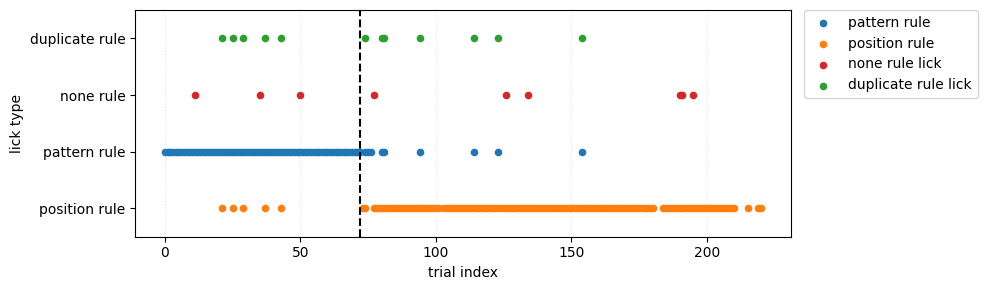

In [1851]:

fig, ax = plt.subplots(figsize=(10, 3))

y_pos     = np.full_like(pos_rule_lick_idx,    1, dtype=float)
y_pattern = np.full_like(pattern_rule_lick_idx,2, dtype=float)

y_false_rule = np.full_like(none_rule_lick_idx, 3, dtype=float)
y_duplicate_rule = np.full_like(duplicate_rule_lick_idx, 4, dtype=float)

ax.scatter(pattern_rule_lick_idx, y_pattern, c='tab:blue',  s=20, label='pattern rule')
ax.scatter(pos_rule_lick_idx,     y_pos,     c='tab:orange',s=20, label='position rule')

ax.scatter(none_rule_lick_idx, y_false_rule, c='tab:red', s=20, label='none rule lick')
ax.scatter(duplicate_rule_lick_idx, y_duplicate_rule, c='tab:green', s=20, label='duplicate rule lick')

for b in boarder_index:
    ax.axvline(b, color='k', linestyle='--', linewidth=1.5)

ax.set_ylim(0.5, 4.5)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(['position rule', 'pattern rule', 'none rule', 'duplicate rule'])

ax.set_xlabel('trial index')
ax.set_ylabel('lick type')
ax.grid(axis='x', linestyle=':', alpha=0.3)

ax.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.
)

ax.set_xlabel('trial index')
ax.set_ylabel('lick type')
ax.grid(axis='x', linestyle=':', alpha=0.3)

ax.legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.
)
plt.tight_layout()
plt.show()


In [1852]:

# len_trials = len(trials)

# zones = np.zeros((3,2))

# for i in (0, 2, 4):
#     zones[i//2, :] = data['zones'][i]

# # past 2 trials
# # fig position 2 + 3 licks + 3 rewards
# # current trial 2 positions + 1 fig + 1 reward
# X = np.zeros((3 * (len_trials - 2),(2 + 3 + 3) * 2 + 2 + 1 + 1))
# Y = np.zeros((3 * (len_trials - 2),))

# for idx in range(2, len_trials):
    
#     X_id = 3 * (idx - 2)
    
#     for current in range(3):
        
#         X_id_curr = X_id + current
        
#         for past in range(2):
#             trial = trials[idx - 2 + past]
#             trial_type = trial['trial_type']
            
#             if 'CAB' in trial_type or 'CBA' in trial_type:
#                 X[X_id_curr, 0 + past * (2 + 3 + 3)] = 1
#                 X[X_id_curr, 1 + past * (2 + 3 + 3)] = 0
#             elif 'ACB' in trial_type or 'BCA' in trial_type:
#                 X[X_id_curr, 0 + past * (2 + 3 + 3)] = 0
#                 X[X_id_curr, 1 + past * (2 + 3 + 3)] = 1
#             elif 'ABC' in trial_type or 'BAC' in trial_type:
#                 X[X_id_curr, 0 + past * (2 + 3 + 3)] = 0
#                 X[X_id_curr, 1 + past * (2 + 3 + 3)] = 0
#             else:
#                 raise ValueError('trial type not recognized')
        
#             lick = trial['lick']
#             reward = trial['reward']
            
#             for zone_idx in range(3):
                
#                 is_lick = np.any((lick >= zones[zone_idx, 0]) & (lick <= zones[zone_idx, 1]))
#                 X[X_id_curr, 2 + zone_idx + past * (2 + 3 + 3)] = 1 if is_lick else 0
        
#                 is_reward = np.any((reward >= zones[zone_idx, 0]) & (reward <= zones[zone_idx, 1]))
#                 X[X_id_curr, 2 + 3 + zone_idx + past * (2 + 3 + 3)] = 1 if is_reward else 0
                
#         trial = trials[idx]
#         trial_type = trial['trial_type']

#         if current == 0:
#             X[X_id_curr, 2 * n + 0] = 1
#             X[X_id_curr, 2 * n + 1] = 0
#         elif current == 1:
#             X[X_id_curr, 2 * n + 0] = 0
#             X[X_id_curr, 2 * n + 1] = 1
#         else:
#             X[X_id_curr, 2 * n + 0] = 0
#             X[X_id_curr, 2 * (2 + 3 + 3) + 1] = 0
        
#         if 'CAB' in trial_type or 'CBA' in trial_type:
#             X[X_id_curr, 2 * (2 + 3 + 3) + 2] = 1 if current == 0 else 0
#         elif 'ACB' in trial_type or 'BCA' in trial_type:
#             X[X_id_curr, 2 * (2 + 3 + 3) + 2] = 1 if current == 1 else 0
#         elif 'ABC' in trial_type or 'BAC' in trial_type:
#             X[X_id_curr, 2 * (2 + 3 + 3) + 2] = 1 if current == 2 else 0
#         else:
#             raise ValueError('trial type not recognized')

#         reward = trial['reward']
#         is_reward = False
#         for zone_idx in range(current):
#             is_reward = is_reward or np.any((reward >= zones[zone_idx, 0]) & (reward <= zones[zone_idx, 1]))
#         X[X_id_curr, 2 * (2 + 3 + 3) + 3] = 1 if is_reward else 0
        
#         lick = trial['lick']
#         is_lick = np.any((lick >= zones[current, 0]) & (lick <= zones[current, 1]))
#         Y[X_id_curr] = 1 if is_lick else 0
        


In [1853]:
selected_trials = []

for idx in range(1,len(trials)):
    if not (('pattern' in trials[idx]['trial_type'] and 'pattern' in trials[idx-1]['trial_type']) or
            ('position' in trials[idx]['trial_type'] and 'position' in trials[idx-1]['trial_type'])):
        selected_trials.extend(np.arange(idx - 25, idx + 25))

# selected_trials = np.arange(len_trials)


In [1854]:

len_trials = len(selected_trials)

zones = np.zeros((3,2))

for i in (0, 2, 4):
    zones[i//2, :] = data['zones'][i]

# past n trials
n = 4
X = np.zeros((len_trials, 2 * n))
Y = np.zeros((len_trials,))
is_selected = np.zeros((len_trials,), dtype=bool)

for idx in range(len_trials):
    
    for past in range(n):
        trial = trials[selected_trials[idx] - n + past]
        trial_type = trial['trial_type']
        lick = trial['lick']
        
        is_pattern = False
        is_position = False
        if 'CAB' in trial_type or 'CBA' in trial_type:
            if np.any((lick >= zones[0][0]) & (lick <= zones[0][1])):
                is_pattern = True
            if np.any((lick >= zones[1][0]) & (lick <= zones[1][1])):
                is_position = True
        elif 'ACB' in trial_type or 'BCA' in trial_type:
            if np.any((lick >= zones[1][0]) & (lick <= zones[1][1])):
                if 'pattern' in trial_type:
                    is_pattern = True
                elif 'position' in trial_type:
                    is_position = True
                else:
                    raise ValueError('trial type not recognized')
        elif 'ABC' in trial_type or 'BAC' in trial_type:
            if np.any((lick >= zones[2][0]) & (lick <= zones[2][1])):
                is_pattern = True
            if np.any((lick >= zones[1][0]) & (lick <= zones[1][1])):
                is_position = True
        else:
            raise ValueError('trial type not recognized')
        
        X[idx, 0 + past * 2] = int(1 * int(is_pattern) + 2 * int(is_position))

        reward  = trial['reward']
        X[idx, 1 + past * 2] = 1 if len(reward) > 0 else 0
        
    trial = trials[selected_trials[idx]]
    lick = trial['lick']
    trial_type = trial['trial_type']
    
    is_pattern = False
    is_position = False
    if 'CAB' in trial_type or 'CBA' in trial_type:
        if np.any((lick >= zones[0][0]) & (lick <= zones[0][1])):
            is_pattern = True
        if np.any((lick >= zones[1][0]) & (lick <= zones[1][1])):
            is_position = True
    elif 'ACB' in trial_type or 'BCA' in trial_type:
        if np.any((lick >= zones[1][0]) & (lick <= zones[1][1])):
            if 'pattern' in trial_type:
                is_pattern = True
            elif 'position' in trial_type:
                is_position = True
            else:
                raise ValueError('trial type not recognized')
    elif 'ABC' in trial_type or 'BAC' in trial_type:
        if np.any((lick >= zones[2][0]) & (lick <= zones[2][1])):
            is_pattern = True
        if np.any((lick >= zones[1][0]) & (lick <= zones[1][1])):
            is_position = True
    else:
        raise ValueError('trial type not recognized')
    
    Y[idx] = int(1 * int(is_pattern) + 2 * int(is_position))
    



In [1855]:

cat_cols = [0 + 2 * past for past in range(n)]

num_cols = [1 + 2 * past for past in range(n)]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)


clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced" 
    ))
])

clf.fit(X, Y)


y_pred = clf.predict(X)

print("混淆矩阵：")
print(confusion_matrix(Y, y_pred))
print("\n分类报告:")
print(classification_report(Y, y_pred))

混淆矩阵：
[[28  0  0]
 [ 1 16  1]
 [ 0  1  3]]

分类报告:
              precision    recall  f1-score   support

         1.0       0.97      1.00      0.98        28
         2.0       0.94      0.89      0.91        18
         3.0       0.75      0.75      0.75         4

    accuracy                           0.94        50
   macro avg       0.89      0.88      0.88        50
weighted avg       0.94      0.94      0.94        50

